In [1]:
import sys
sys.path.insert(1, '../../functions/')

from settings import runcry

from crystal_io import read_input
from crystal_io import write_input

from extract_info import final_energy

from settings import clean_wf

import re
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import time

In [2]:
#directory where the input is saved
directory = '../data' 

#name of the input (including the extension)
input_name = 'mgo.d12' 

file_path = join(directory,input_name)

#First k point grid to be sampled
initial = 6

#Final k point grid to be sampled
final = 12

#Step between grids
step = 1

#Run the calculation? (True = run , False = only write the inputs, 'Analyse' = analyse results of a previous calculation)
run = True

#Delete the wave function files after running the calculation
clean = True

#please DO NOT modify the following line
sample = [i for i in range(initial,final,step)]    

In [3]:
#Read the input and store it in its several blocks
geom_block,optgeom_block,bs_block,func_block,scf_block = read_input(file_path)

In [4]:
#This is the function that runs the calculation (move to the following cell to analyse the results)
def kpc(directory,input_name,sample,geom_block,bs_block,func_block,scf_block,run,clean):
    energy = []
    files_not_found = []    
    for i,shrink in enumerate(sample):
        input_convergence = join(directory,input_name[:-4]+'_k%s.d12'%(str(shrink)))
        if run != 'Analyse':
            for j,line in enumerate(scf_block):
                if re.match(r'SHRINK',line): 
                    scf_block[j+1] = str(shrink)+' '+str(shrink*2)+'\n'        
            write_input(input_convergence,geom_block,bs_block,func_block,scf_block)
        if run == True:
            time_0 = time.time()
            runcry(input_convergence[:-4])
            time.sleep(1)
            if clean == True:
                clean_wf(directory,input_convergence)
            E_final = final_energy(input_convergence[:-3]+'out')
            if type(E_final) == float:                
                if i > 0:           
                    energy.append([int(shrink),float(E_final),float(E0_final-E_final),time.time()-time_0])                    
                else:
                    energy.append([int(shrink),float(E_final),'-',time.time()-time_0])
                E0_final = E_final
            else:
                files_not_found.append(input_convergence[:-3]+'out')
        if run == 'Analyse':
            E_final = final_energy(input_convergence[:-3]+'out')
            if type(E_final) == float:                
                if i > 0:           
                    energy.append([int(shrink),float(E_final),float(E0_final-E_final)])                    
                else:
                    energy.append([int(shrink),float(E_final),'-'])
                E0_final = E_final
            
        if len(files_not_found) > 0:
            print('The following outputs were not found: '+','.join(files_not_found))  
    if run != False:
        #Plot the Delta E
        fig, ax1 = plt.subplots(1,1)
        energy_arr = np.array(energy)
        energy_arr = energy_arr[1:,:].astype('f')
        ax1.plot(energy_arr[:,0], energy_arr[:,2],'o-', c='black')
        ax1.set_title('Total energy convergence', size = 18)
        ax1.set_xticks(energy_arr[:,0].astype('float64'))
        ax1.set_xlabel('Shrinking factor', size =12)
        ax1.set_ylabel('Delta E (eV)', size =12)
        ax1.grid()

        #Generate the result table
        if run == True:
            pd.set_option('display.float_format', '{:.3E}'.format)
            energy_df = pd.DataFrame(energy, columns=['Shrink','Final Energy','Delta E','Time'])
            energy_df['Final Energy'].astype('float64').dtypes
            energy_df['Delta E'][1:].astype('float64').dtypes
            energy_df.set_index('Shrink', inplace = True)
        if run == 'Analyse':
            pd.set_option('display.float_format', '{:.3E}'.format)
            energy_df = pd.DataFrame(energy, columns=['Shrink','Final Energy','Delta E'])
            energy_df['Final Energy'].astype('float64').dtypes
            energy_df['Delta E'][1:].astype('float64').dtypes
            energy_df.set_index('Shrink', inplace = True)
            
    if run != False:
        return energy_df, energy_arr
    else:
        return 'Inputs saved'

,Final Energy,Delta E,Time
Shrink,,,
6,-7.495E+03,-,9.562E+00
7,-7.495E+03,8.451E-05,9.506E+00
8,-7.495E+03,1.317E-05,9.482E+00
9,-7.495E+03,2.078E-06,9.565E+00
10,-7.495E+03,4.680E-07,9.826E+00
11,-7.495E+03,9.388E-08,9.952E+00


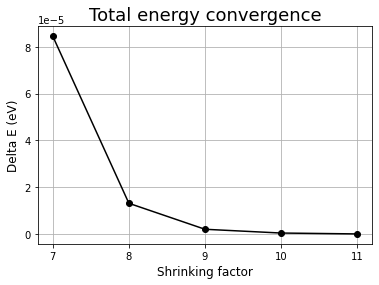

In [5]:
if run != False:
    energy_df, energy_arr = kpc(directory,input_name,sample,geom_block,bs_block,func_block,scf_block,run,clean)
    display(energy_df)
else:
    display(kpc(directory,input_name,sample,geom_block,bs_block,func_block,scf_block,run,clean))